### Videos Summary 
_____
Summary information for trending videos dataset

In [1]:
import pandas as pd
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import numpy as np
import statsmodels.api as sm

nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from scipy import stats

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alexandre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alexandre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [401]:
columns =  ['views', 'likes', 'dislikes', 'comment_count', 'trending_date', 'category_name', 'duration', 
            'tags', 'tags_rate', 'title', 'channel_title', 'tags_positive', 'tags_neutral', 'tags_negative',
            'title_rate', 'title_positive', 'title_neutral', 'title_negative', 'publish_time']

trends = pd.read_csv('../../../../resources/datasets/USvideos.csv', parse_dates=['publish_time'], index_col='video_id')
duration = pd.read_csv('../../../../resources/datasets/USvideos_duration.csv',usecols=['video_id', 'duration'], index_col='video_id')
sentimental = pd.read_csv('../../../../resources/datasets/US_sentimental.csv', index_col='video_id')
creators = pd.read_csv('../../../../resources/datasets/USchannels.csv', index_col='video_id')

df = pd.merge(trends, duration, how='outer', on=['video_id'])
df = df.merge(sentimental, how='outer', on=['video_id'])

df.head(5)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,...,description,duration,title_negative,title_neutral,title_positive,title_rate,tags_negative,tags_neutral,tags_positive,tags_rate
video_id,,,,,,,,,,,,,,,,,,,,,
2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01,SHANtell martin,748374,57527,2966,15954,...,SHANTELL'S CHANNEL - https://www.youtube.com/s...,678,0.0,82.2,17.8,Positive,0.0,100.0,0.0,Neutral
2kyS6SvSYSE,17.15.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01,SHANtell martin,2188590,88099,7150,24225,...,SHANTELL'S CHANNEL - https://www.youtube.com/s...,678,0.0,82.2,17.8,Positive,0.0,100.0,0.0,Neutral
2kyS6SvSYSE,17.16.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01,SHANtell martin,2325233,91111,7543,21450,...,SHANTELL'S CHANNEL - https://www.youtube.com/s...,678,0.0,82.2,17.8,Positive,0.0,100.0,0.0,Neutral
2kyS6SvSYSE,17.17.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01,SHANtell martin,2400741,92831,7687,21714,...,SHANTELL'S CHANNEL - https://www.youtube.com/s...,678,0.0,82.2,17.8,Positive,0.0,100.0,0.0,Neutral
2kyS6SvSYSE,17.18.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01,SHANtell martin,2468267,94303,7802,21866,...,SHANTELL'S CHANNEL - https://www.youtube.com/s...,678,0.0,82.2,17.8,Positive,0.0,100.0,0.0,Neutral


#### Data Cleanup
____________________

In [402]:
# import category description
category_file = '../../../../resources/datasets/US_category_id.json'

map_category = {}
with open(category_file) as jsonfile:
    categories = json.load(jsonfile)
    
for item in categories['items']:
    map_category[int(item['id'])] = item["snippet"]["title"]

df['category_name'] = df['category_id'].map(map_category)
df['category_name'] = df['category_name'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40949 entries, 2kyS6SvSYSE to yz7Xq3T0YPs
Data columns (total 25 columns):
trending_date             40949 non-null object
title                     40949 non-null object
channel_title             40949 non-null object
category_id               40949 non-null int64
publish_time              40949 non-null datetime64[ns]
tags                      40949 non-null object
views                     40949 non-null int64
likes                     40949 non-null int64
dislikes                  40949 non-null int64
comment_count             40949 non-null int64
thumbnail_link            40949 non-null object
comments_disabled         40949 non-null bool
ratings_disabled          40949 non-null bool
video_error_or_removed    40949 non-null bool
description               40379 non-null object
duration                  40949 non-null int64
title_negative            40949 non-null float64
title_neutral             40949 non-null float64
title_positive    

In [403]:
# fix trendind_date field
df['trending_date'] = df['trending_date'].apply(lambda dt: datetime.datetime.strptime(dt, '%y.%d.%m'))

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40949 entries, 2kyS6SvSYSE to yz7Xq3T0YPs
Data columns (total 25 columns):
trending_date             40949 non-null datetime64[ns]
title                     40949 non-null object
channel_title             40949 non-null object
category_id               40949 non-null int64
publish_time              40949 non-null datetime64[ns]
tags                      40949 non-null object
views                     40949 non-null int64
likes                     40949 non-null int64
dislikes                  40949 non-null int64
comment_count             40949 non-null int64
thumbnail_link            40949 non-null object
comments_disabled         40949 non-null bool
ratings_disabled          40949 non-null bool
video_error_or_removed    40949 non-null bool
description               40379 non-null object
duration                  40949 non-null int64
title_negative            40949 non-null float64
title_neutral             40949 non-null float64
title_posi

In [404]:
# Considering only the last record for each video for the summary analysis. 
df_unique = df[columns].sort_values(by='trending_date',ascending=False).groupby(by='video_id').first()

df_unique.head(5)

,views,likes,dislikes,comment_count,trending_date,category_name,duration,tags,tags_rate,title,channel_title,tags_positive,tags_neutral,tags_negative,title_rate,title_positive,title_neutral,title_negative,publish_time
video_id,,,,,,,,,,,,,,,,,,,
-0CMnp02rNY,800359,9773,332,423,2018-06-11,Entertainment,308,"ellen|""ellen degeneres""|""the ellen show""|""elle...",Positive,Mindy Kaling's Daughter Had the Perfect Reacti...,TheEllenShow,8.3,91.7,0.0,Positive,27.0,73.0,0.0,2018-06-04 13:00:00
-0NYY8cqdiQ,563746,4429,54,94,2018-02-01,Entertainment,303,"megan mullally|""megan""|""mullally""|""will and gr...",Positive,Megan Mullally Didn't Notice the Interesting P...,TheEllenShow,24.1,72.3,3.6,Negative,0.0,79.9,20.1,2018-01-29 14:00:39
-1Hm41N0dUs,2058516,41248,580,1484,2018-05-01,Comedy,237,"jimmy|""jimmy kimmel""|""jimmy kimmel live""|""late...",Positive,Cast of Avengers: Infinity War Draws Their Cha...,Jimmy Kimmel Live,27.4,52.2,20.4,Negative,0.0,64.2,35.8,2018-04-27 07:30:02
-1yT-K3c6YI,231341,7734,212,846,2017-12-02,People & Blogs,999,"youtube quiz|""youtuber quiz""|""truth or dare""|""...",Positive,YOUTUBER QUIZ + TRUTH OR DARE W/ THE MERRELL T...,Molly Burke,14.2,67.9,17.9,Positive,24.5,75.5,0.0,2017-11-28 18:30:43
-2RVw2_QyxQ,71089,460,27,20,2017-11-16,Education,20767,"Chess|""Saint Louis""|""Club""",Neutral,2017 Champions Showdown: Day 3,Saint Louis Chess Club,0.0,100.0,0.0,Positive,53.1,46.9,0.0,2017-11-12 02:39:01


In [405]:
# adding tag length column
df_unique['tags_length'] = df_unique['tags'].map(lambda tag: len(tag.split('|')))
df_unique.head(5)

,views,likes,dislikes,comment_count,trending_date,category_name,duration,tags,tags_rate,title,channel_title,tags_positive,tags_neutral,tags_negative,title_rate,title_positive,title_neutral,title_negative,publish_time,tags_length
video_id,,,,,,,,,,,,,,,,,,,,
-0CMnp02rNY,800359,9773,332,423,2018-06-11,Entertainment,308,"ellen|""ellen degeneres""|""the ellen show""|""elle...",Positive,Mindy Kaling's Daughter Had the Perfect Reacti...,TheEllenShow,8.3,91.7,0.0,Positive,27.0,73.0,0.0,2018-06-04 13:00:00,33
-0NYY8cqdiQ,563746,4429,54,94,2018-02-01,Entertainment,303,"megan mullally|""megan""|""mullally""|""will and gr...",Positive,Megan Mullally Didn't Notice the Interesting P...,TheEllenShow,24.1,72.3,3.6,Negative,0.0,79.9,20.1,2018-01-29 14:00:39,33
-1Hm41N0dUs,2058516,41248,580,1484,2018-05-01,Comedy,237,"jimmy|""jimmy kimmel""|""jimmy kimmel live""|""late...",Positive,Cast of Avengers: Infinity War Draws Their Cha...,Jimmy Kimmel Live,27.4,52.2,20.4,Negative,0.0,64.2,35.8,2018-04-27 07:30:02,23
-1yT-K3c6YI,231341,7734,212,846,2017-12-02,People & Blogs,999,"youtube quiz|""youtuber quiz""|""truth or dare""|""...",Positive,YOUTUBER QUIZ + TRUTH OR DARE W/ THE MERRELL T...,Molly Burke,14.2,67.9,17.9,Positive,24.5,75.5,0.0,2017-11-28 18:30:43,8
-2RVw2_QyxQ,71089,460,27,20,2017-11-16,Education,20767,"Chess|""Saint Louis""|""Club""",Neutral,2017 Champions Showdown: Day 3,Saint Louis Chess Club,0.0,100.0,0.0,Positive,53.1,46.9,0.0,2017-11-12 02:39:01,3


In [406]:
### Remove NaN values from creators Dataframe

creators.dropna(inplace=True)

#### 1. Videos Summary
_____
Estimate the numbers of people a campaign could reach

In [407]:
total_videos = df_unique.shape[0]

max_views = df_unique['views'].max()
avg_views = df_unique['views'].mean()
med_views = df_unique['views'].median()
min_views = df_unique['views'].min()
std_views = df_unique['views'].std()
trend_min = df_unique['trending_date'].min()
trend_max = df_unique['trending_date'].max()
channels  = df_unique['channel_title'].nunique()

summary_data = [{
    'Videos'             : total_videos,
    'Channels'           : channels,
    'Max of Views'       : max_views,
    'Average of Views'   : avg_views,
    'Median of Views'    : med_views,
    'Minimum of Views'   : min_views,
    'Standard Deviation' : std_views,
    'Start date'         : trend_min,
    'End date'           : trend_max
}]

videos_summary = pd.DataFrame(data=summary_data, columns=list(summary_data[0].keys()))
videos_summary['Videos'] = videos_summary['Videos'].map('{:,}'.format)
videos_summary['Channels'] = videos_summary['Channels'].map('{:,}'.format)
videos_summary['Max of Views'] = videos_summary['Max of Views'].map('{:,}'.format)
videos_summary['Average of Views'] = videos_summary['Average of Views'].map('{:,.0f}'.format)
videos_summary['Median of Views'] = videos_summary['Median of Views'].map('{:,.0f}'.format)
videos_summary['Minimum of Views'] = videos_summary['Minimum of Views'].map('{:,.0f}'.format)
videos_summary['Standard Deviation'] = videos_summary['Standard Deviation'].map('{:,.0f}'.format)

videos_summary

,Videos,Channels,Max of Views,Average of Views,Median of Views,Minimum of Views,Standard Deviation,Start date,End date
0,"6,351","2,198","225,211,923","1,962,117","518,107",559,"7,060,057",2017-11-14,2018-06-14


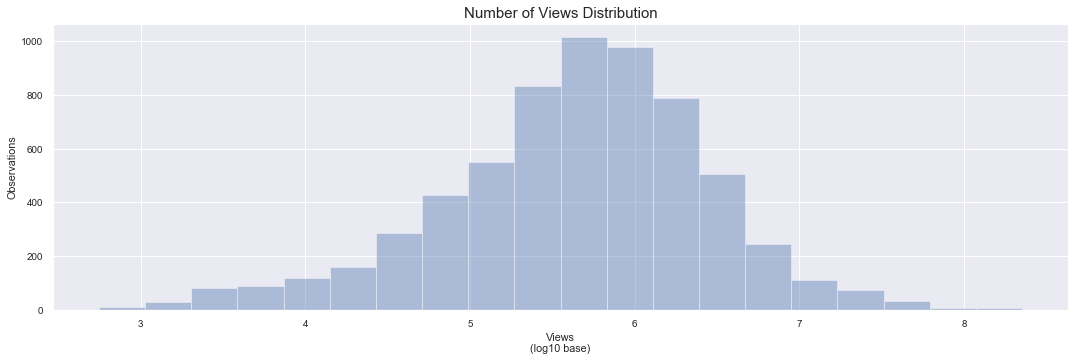

In [410]:
# Views distribution

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

sns.set_style("dark")
sns.set(font_scale=0.5)

ax = sns.distplot(a=np.log10(df_unique['views'].values),label='Number of Views',hist=True, kde=False, rug=False, bins=20)

ax.set_title('Number of Views Distribution', fontsize=15)
ax.set_xlabel('Views\n(log10 base)')
ax.set_ylabel('Observations')
ax.set_yscale('linear')
ax.set_xlim(auto=True)
ax.set_ylim(auto=True)


plt.tight_layout()
plt.show()

#### Quanties for Numbers of Views
_____
Describe the total numbers of views in perceptual categories. This dataset can give a better understanding of the potential number of people a trending video can reach.

In [10]:
quanties = [0.01, 0.10, 0.20, 0.30, 0.40, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
series_quanties = df_unique['views'].quantile(quanties)

record = {}

for item in series_quanties.items():    
    record[str(int(item[0]*100)) + '%'] = f'{item[1]:,.0f}'
    
pd.DataFrame(data=[record], columns=list(record.keys()))    


,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%
0,"2,678","38,447","107,120","218,669","343,957","518,107","782,535","1,180,077","1,888,088","3,689,210","25,189,198"


#### Trending Videos over Time
_____
Describe the total of trending videos per day over time

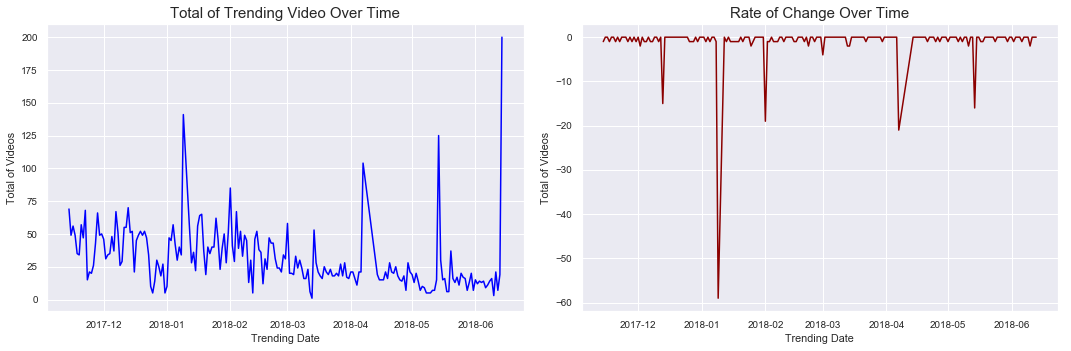

In [414]:
sns.set(font_scale=0.9)

ts_trend = df_unique['trending_date'].value_counts().reset_index().rename(columns={'index' : 'Date', 'trending_date' : 'Videos'})
ts_trend['rate_change'] = ts_trend['Videos'].diff()

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)


ax1 = sns.lineplot(x=ts_trend['Date'], y=ts_trend['Videos'], color='blue', ax=ax1)
ax2 = sns.lineplot(x=ts_trend['Date'], y=ts_trend['rate_change'], color='darkred', ax=ax2)

ax1.set_xlim(auto=True)
ax1.set_ylim(auto=True)

ax1.set_title('Total of Trending Video Over Time', fontsize=15)
ax1.set_xlabel('Trending Date')
ax1.set_ylabel('Total of Videos')

ax2.set_xlim(auto=True)
ax2.set_ylim(auto=True)

ax2.set_title('Rate of Change Over Time', fontsize=15)
ax2.set_xlabel('Trending Date')
ax2.set_ylabel('Total of Videos')

plt.tight_layout()
plt.show()

#### Days Taken for a video be classified as a trending video
_____

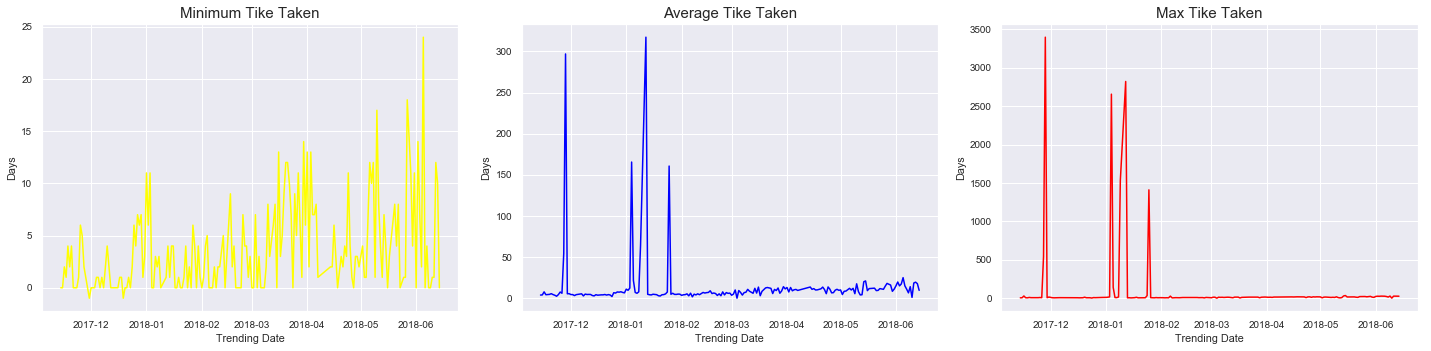

In [445]:
df_publish = df_unique[['trending_date', 'publish_time']].copy(deep=True)
df_publish['time_taken'] = (df_publish['trending_date'] - df_publish['publish_time']).dt.days
cond [df_publish['time_taken'] > 0]

df_publish_summary = df_publish[cond].groupby(by='trending_date', as_index=False).agg({
                                                                                    'time_taken' : ['min', 'mean', 'max']
                                                                                })
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)


ax1 = sns.lineplot(x=df_publish_summary['trending_date'], y=df_publish_summary['time_taken']['min'], color='yellow', ax=ax1)
ax1.set_xlim(auto=True)
ax1.set_ylim(auto=True)

ax1.set_title('Minimum Tike Taken', fontsize=15)
ax1.set_xlabel('Trending Date')
ax1.set_ylabel('Days')

ax2 = sns.lineplot(x=df_publish_summary['trending_date'], y=df_publish_summary['time_taken']['mean'], color='blue', ax=ax2)
ax2.set_xlim(auto=True)
ax2.set_ylim(auto=True)

ax2.set_title('Average Tike Taken', fontsize=15)
ax2.set_xlabel('Trending Date')
ax2.set_ylabel('Days')

ax2 = sns.lineplot(x=df_publish_summary['trending_date'], y=df_publish_summary['time_taken']['max'], color='red', ax=ax3)
ax2.set_xlim(auto=True)
ax2.set_ylim(auto=True)

ax2.set_title('Max Tike Taken', fontsize=15)
ax2.set_xlabel('Trending Date')
ax2.set_ylabel('Days')


plt.tight_layout()
plt.show()

#### 2. Views per Category
______

Identity the performance of the categories areas

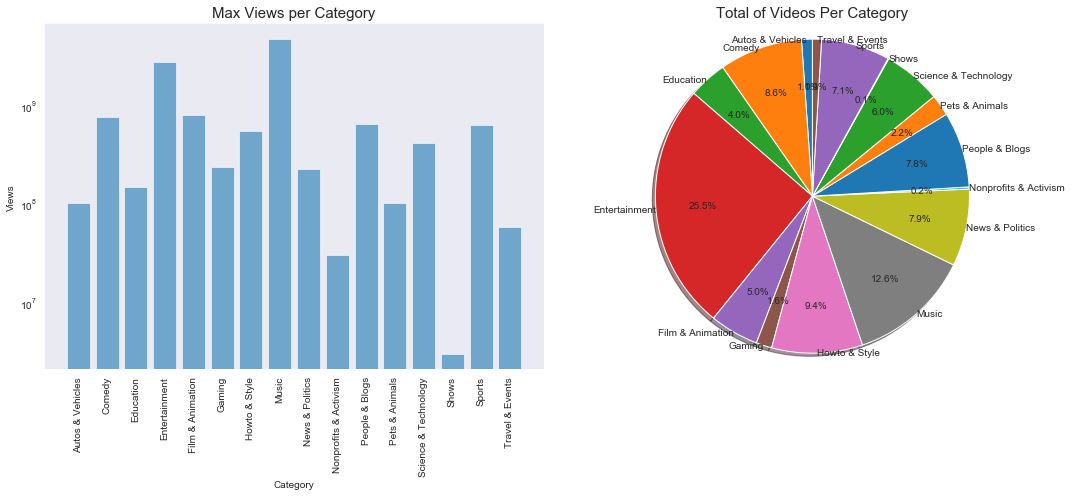

In [11]:
df_category = df_unique[['category_name', 'views']].groupby(by='category_name', as_index=False).agg({'views' : ['count', 'sum']})

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.bar(df_category['category_name'], df_category['views']['sum'],align="center", alpha=0.6, orientation='vertical',log=True)
ax1.set_title('Max Views per Category', fontsize=15)
ax1.set_xlabel('Category')
ax1.set_ylabel('Views')
ax1.set_xticklabels(df_category['category_name'], rotation='vertical')
ax1.set_xlim(auto=True)
ax1.set_ylim(auto=True)


ax2.pie(x=df_category['views']['count'], labels=df_category['category_name'], shadow=True, startangle=90, autopct='%1.1f%%',labeldistance=1.0,pctdistance=0.7)
ax2.set_title('Total of Videos Per Category', fontsize=15)
ax2.axis('equal')
ax2.set_xlim(auto=True)
ax2.set_ylim(auto=True)

plt.tight_layout()
plt.show()

#### 2. Distribution per Category
______

Identity how the numbers of views is distribute accross the categories

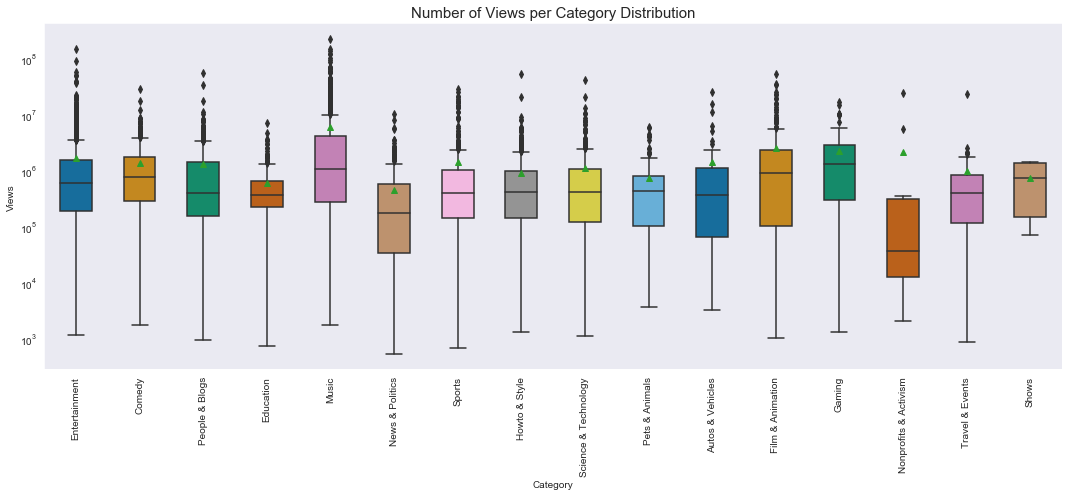

In [12]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)

ax = sns.boxplot(x=df_unique['category_name'], y=df_unique['views'], width=0.5,palette="colorblind", data=df_unique,showfliers=True,showmeans=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax.set_xlim(auto=True)
ax.set_ylim(auto=True)

ax.set_title('Number of Views per Category Distribution', fontsize=15)
ax.set_xlabel('Category')
ax.set_ylabel('Views')
ax.set_yscale('log')


plt.tight_layout()
plt.show()

#### 3. Correlation between categories
_____
Observe the correlation between Views, Like, Dislikes, Comments, Duration

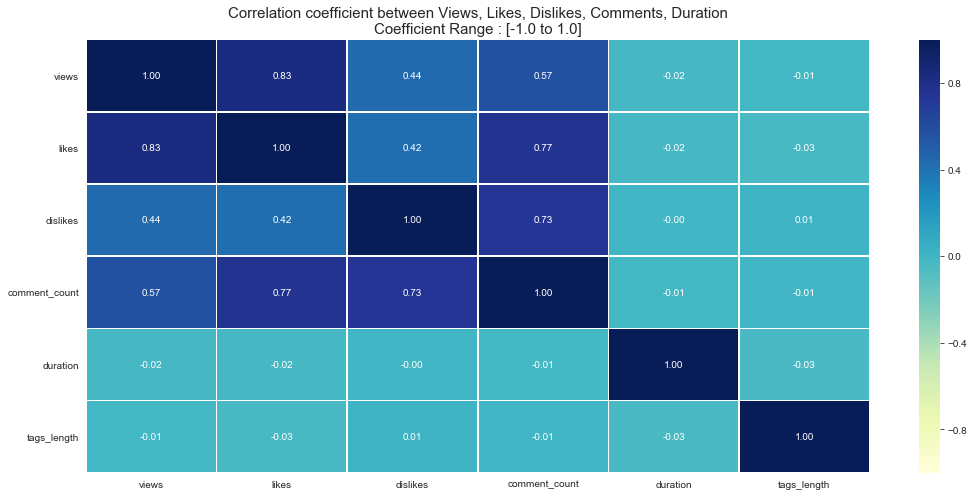

In [13]:
columns = ['views', 'likes', 'dislikes', 'comment_count', 'duration', 'tags_length']
df_corr = df_unique[columns].corr()

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)

ax.set_title('Correlation coefficient between Views, Likes, Dislikes, Comments, Duration\nCoefficient Range : [-1.0 to 1.0]', fontsize=15)

ax = sns.heatmap(df_corr, annot=True, fmt='.2f',vmin=-1.0, vmax=1.0, cmap='YlGnBu', center=0, linewidths=.5)

plt.tight_layout()
plt.show()

#### 4. Ratios per Categories
______________


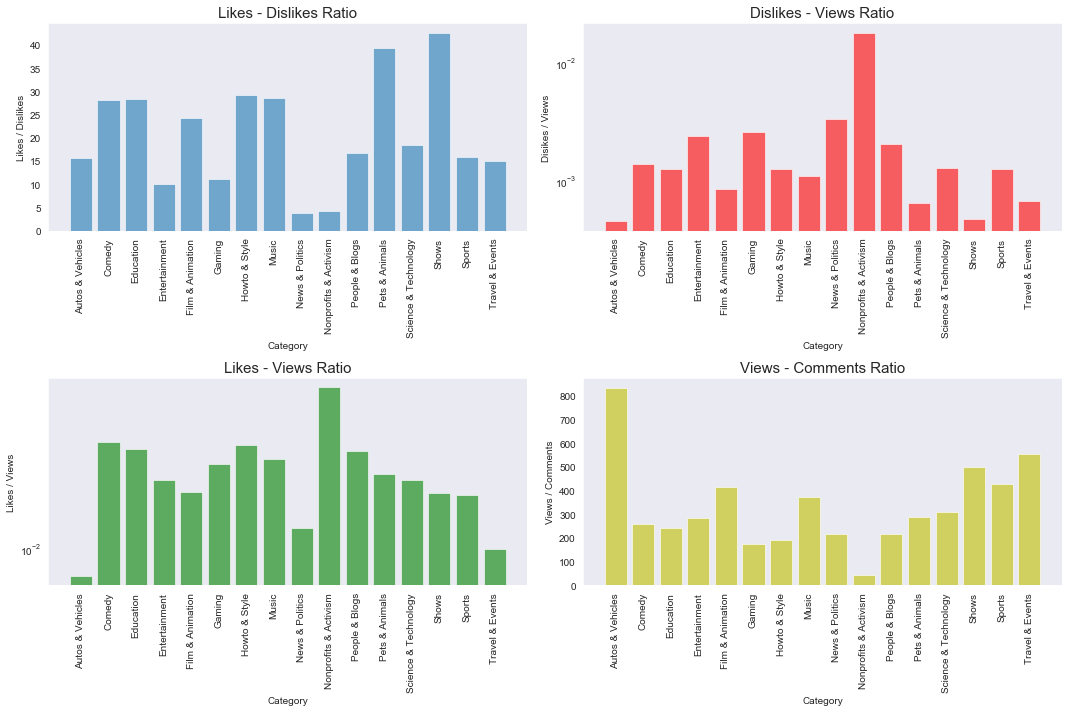

In [14]:
df_ratio = df_unique.groupby(by='category_name',as_index=False).agg({
    'likes'         : ['sum'],
    'dislikes'      : ['sum'],
    'views'         : ['sum'],
    'comment_count' : ['sum']
})

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)


ax1.bar(df_ratio['category_name'], df_ratio['likes']['sum'] / df_ratio['dislikes']['sum'],align="center", alpha=0.6, orientation='vertical',log=False)
ax1.set_title('Likes - Dislikes Ratio', fontsize=15)
ax1.set_xlabel('Category')
ax1.set_ylabel('Likes / Dislikes')
ax1.set_xticklabels(df_ratio['category_name'], rotation='vertical')
ax1.set_xlim(auto=True)
ax1.set_ylim(auto=True)


ax2.bar(df_ratio['category_name'], df_ratio['dislikes']['sum'] / df_ratio['views']['sum'],align="center", alpha=0.6, orientation='vertical',log=True, color='r')
ax2.set_title('Dislikes - Views Ratio', fontsize=15)
ax2.set_xlabel('Category')
ax2.set_ylabel('Disikes / Views')
ax2.set_xticklabels(df_ratio['category_name'], rotation='vertical')
ax2.set_xlim(auto=True)
ax2.set_ylim(auto=True)

ax3.bar(df_ratio['category_name'], df_ratio['likes']['sum'] / df_ratio['views']['sum'],align="center", alpha=0.6, orientation='vertical',log=True, color='g')
ax3.set_title('Likes - Views Ratio', fontsize=15)
ax3.set_xlabel('Category')
ax3.set_ylabel('Likes / Views')
ax3.set_xticklabels(df_ratio['category_name'], rotation='vertical')
ax3.set_xlim(auto=True)
ax3.set_ylim(auto=True)

ax4.bar(df_ratio['category_name'], df_ratio['views']['sum'] / df_ratio['comment_count']['sum'],align="center", alpha=0.6, orientation='vertical',log=False, color='y')
ax4.set_title('Views - Comments Ratio', fontsize=15)
ax4.set_xlabel('Category')
ax4.set_ylabel('Views / Comments')
ax4.set_xticklabels(df_ratio['category_name'], rotation='vertical')
ax4.set_xlim(auto=True)
ax4.set_ylim(auto=True)

plt.tight_layout()

plt.show()

#### 5. Tags
______________
Top tags used per category

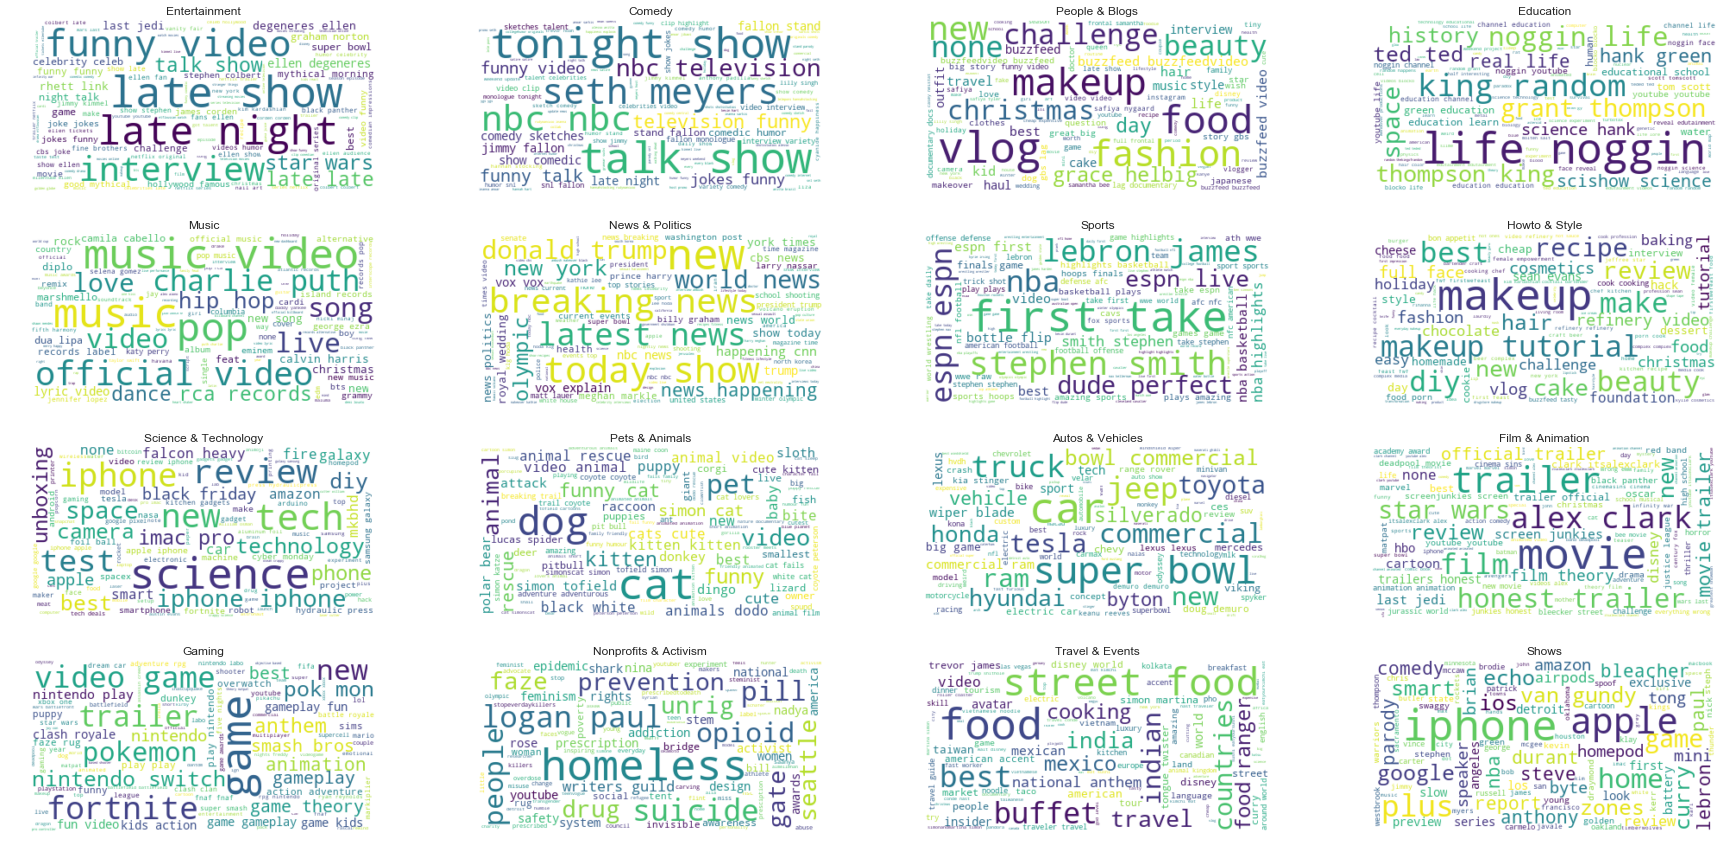

In [15]:
fig = plt.figure(figsize=(25, 12))
stopwords_list = list(stopwords.words('english'))

def normalize_data(tag):    
    tag_word = tag.str.lower().str.cat(sep=' ')
    tag_word = re.sub('[^A-Za-z]+', ' ', tag_word)
    tokens = word_tokenize(tag_word)
    filter_sentence = [word for word in tokens if not word in stopwords_list]
    filter_one_chr = [word for word in filter_sentence if len(word) > 2]
    
    return [word for word in filter_one_chr if not word.isdigit()]
    
def plot_word_cloud(word_data, x, y, i, title):
    ax = fig.add_subplot(x, y, i)
    
    cloud = WordCloud(background_color = 'white', max_words = 100,  max_font_size = 50)
    cloud.generate(' '.join(word_data))
    
    ax.imshow(cloud,interpolation='bilinear')
    ax.set_title(label=title)
    ax.axis('off')

index = 1

for category in df_unique['category_name'].unique():    
    cond = df_unique['category_name'] == category
    plot_word_cloud(normalize_data(df_unique[cond]['tags']), 4,4, index, category)
    index = index + 1
    
plt.tight_layout()
plt.show()    

#### 6. Sentimental Analysis
______________

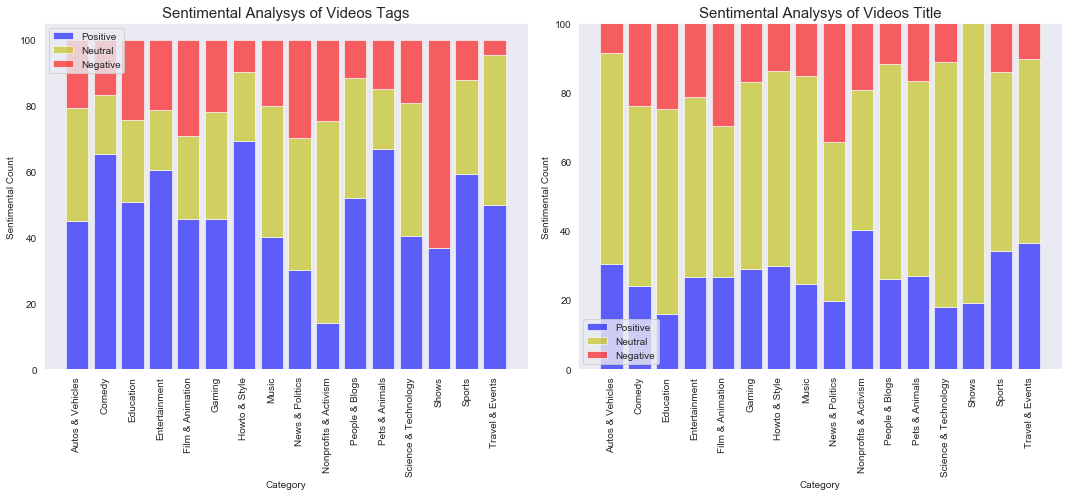

In [16]:
df_sentimental = df[['category_name','tags_rate', 'views']].groupby(by=['tags_rate', 'category_name'], as_index=False).count()

cond1 = df_sentimental['tags_rate'] == 'Positive'
cond2 = df_sentimental['tags_rate'] == 'Neutral'
cond3 = df_sentimental['tags_rate'] == 'Negative'

df_positive = df_sentimental[cond1][['category_name', 'views']] 
df_positive.set_index(keys=['category_name'], inplace=True)
df_positive.fillna(value=0, inplace=True)

df_neutral = df_sentimental[cond2][['category_name', 'views']] 
df_neutral.set_index(keys=['category_name'], inplace=True)
df_neutral.fillna(value=0, inplace=True)

df_negative = df_sentimental[cond3][['category_name', 'views']] 
df_negative.set_index(keys=['category_name'], inplace=True)
df_negative.fillna(value=0, inplace=True)

df_total = df_positive + df_neutral + df_negative

df_total['perc_positive'] = (df_positive['views'] / df_total['views'])*100
df_total['perc_neutral'] = (df_neutral['views'] / df_total['views'])*100
df_total['perc_negative'] = (df_negative['views'] / df_total['views'])*100
df_total.reset_index(drop=False, inplace=True)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 2, 1)

ax1.bar(df_total['category_name'], df_total['perc_positive'], align="center", width=0.8, alpha=0.6, orientation='vertical',log=False, label='Positive', color='b')
ax1.bar(df_total['category_name'], df_total['perc_neutral'], align="center", width=0.8, alpha=0.6, orientation='vertical',log=False, label='Neutral', color='y', bottom=df_total['perc_positive'])
ax1.bar(df_total['category_name'], df_total['perc_negative'], align="center", width=0.8, alpha=0.6, orientation='vertical',log=False, label='Negative', color='r', bottom=df_total['perc_positive']+df_total['perc_neutral'])

ax1.set_title('Sentimental Analysys of Videos Tags', fontsize=15)
ax1.set_xlabel('Category')
ax1.set_ylabel('Sentimental Count')
ax1.set_xticklabels(df_total['category_name'], rotation='vertical')
ax1.set_xlim(auto=True)
ax1.set_ylim(auto=True)
ax1.legend()


df_sentimental_title = df[['category_name','title_rate', 'views']].groupby(by=['title_rate', 'category_name'], as_index=False).count()

cond1 = df_sentimental_title['title_rate'] == 'Positive'
cond2 = df_sentimental_title['title_rate'] == 'Neutral'
cond3 = df_sentimental_title['title_rate'] == 'Negative'

df_positive_title = df_sentimental_title[cond1][['category_name', 'views']] 
df_positive_title.set_index(keys=['category_name'], inplace=True)
df_positive_title.fillna(value=0, inplace=True)

df_neutral_title = df_sentimental_title[cond2][['category_name', 'views']] 
df_neutral_title.set_index(keys=['category_name'], inplace=True)
df_neutral_title.fillna(value=0, inplace=True)

df_negative_title = df_sentimental_title[cond3][['category_name', 'views']] 
df_negative_title.set_index(keys=['category_name'], inplace=True)
df_negative_title.fillna(value=0, inplace=True)

df_total_title = df_positive_title + df_neutral_title + df_negative_title

df_total_title['perc_positive'] = (df_positive_title['views'] / df_total_title['views'])*100
df_total_title['perc_neutral'] = (df_neutral_title['views'] / df_total_title['views'])*100
df_total_title['perc_negative'] = (df_negative_title['views'] / df_total_title['views'])*100
df_total_title.reset_index(drop=False, inplace=True)

ax2 = fig.add_subplot(1, 2, 2)

ax2.bar(df_total_title['category_name'], df_total_title['perc_positive'], align="center", width=0.8, alpha=0.6, orientation='vertical',log=False, label='Positive', color='b')
ax2.bar(df_total_title['category_name'], df_total_title['perc_neutral'], align="center", width=0.8, alpha=0.6, orientation='vertical',log=False, label='Neutral', color='y', bottom=df_total_title['perc_positive'])
ax2.bar(df_total_title['category_name'], df_total_title['perc_negative'], align="center", width=0.8, alpha=0.6, orientation='vertical',log=False, label='Negative', color='r', bottom=df_total_title['perc_positive']+df_total_title['perc_neutral'])

ax2.set_title('Sentimental Analysys of Videos Title', fontsize=15)
ax2.set_xlabel('Category')
ax2.set_ylabel('Sentimental Count')
ax2.set_xticklabels(df_total['category_name'], rotation='vertical')
ax2.set_xlim(auto=True)
ax2.set_ylim(auto=True)
ax2.legend()

plt.tight_layout()
plt.show()

In [17]:
#fig = plt.figure(figsize=(15, 7))
#ax1 = fig.add_subplot(1, 1, 1)
#https://www.programcreek.com/python/example/96201/seaborn.regplot

#f, ax = plt.subplots(figsize=(10, 6))

#cond = df_unique['tags_rate'] == 'Positive'
#ax1 = sns.regplot(x='tags_positive', y='views',data=df_unique[['tags_positive', 'views']][cond], fit_reg=True, 
#                  ax=ax,scatter=True,marker='+', color='blue', ci=None)
#ax1.set_yscale('log')
#ax1.set_xscale('linear')
#ax1.set_xlabel('% Positive')
#ax1.set_ylabel('Views')

#cond = df_unique['title_rate'] == 'Positive'
#ax2 = sns.regplot(x='title_positive', y='views',data=df_unique[['title_positive', 'views']][cond], fit_reg=True, 
#                  ax=ax,scatter=True,marker='+', color='blue', ci=None)
#ax2.set_yscale('log')
#ax2.set_xscale('linear')
#ax2.set_xlabel('% Positive')
#ax2.set_ylabel('Views')

#cond = df_unique['title_rate'] == 'Negative'
#ax2 = sns.regplot(x='title_negative', y='views',data=df_unique[['title_negative', 'views']][cond], fit_reg=True, 
#                  ax=ax,scatter=True,marker='+', color='red') 
#ax2.set_yscale('log')
#ax2.set_xscale('linear')
#ax2.set_xlabel('% Positive')
#ax2.set_ylabel('Views')


#cond = df_unique['tags_rate'] == 'Negative'
#ax2 = sns.regplot(x='tags_negative', y='views',data=df_unique[['tags_negative', 'views']][cond], fit_reg=True, ax=ax,scatter=True,marker='+', color='red', ci=None)
#ax2.set_yscale('log')
#ax2.set_xscale('linear')
#ax2.set_xlabel('% Positive')
#ax2.set_ylabel('Views')


#cond = df_unique['tags_rate'] == 'Neutral'
#ax2 = sns.regplot(x='tags_neutral', y='views',data=df_unique[['tags_neutral', 'views']][cond], fit_reg=True, ax=ax,scatter=True,marker='+', color='yellow', ci=None)
#ax2.set_yscale('log')
#ax2.set_xscale('linear')
#ax2.set_xlabel('% Positive')
#ax2.set_ylabel('Views')

#ax1.set(yscale='log')
#ax1.set_xlabels('% Positive')
#ax1.set_ylabels('Views')

#ax1.bar(df_category['category_name'], df_category['views']['sum'],align="center", alpha=0.6, orientation='vertical',log=True)
#ax1.set_title('Max Views per Category', fontsize=15)
#ax1.set_xlabel('Category')
#ax1.set_ylabel('Views')
#ax1.set_xticklabels(df_category['category_name'], rotation='vertical')
#ax1.set_xlim(auto=True)
#ax1.set_ylim(auto=True)


#plt.tight_layout()
#plt.show()



### Correlation between Title Sentiment and Views

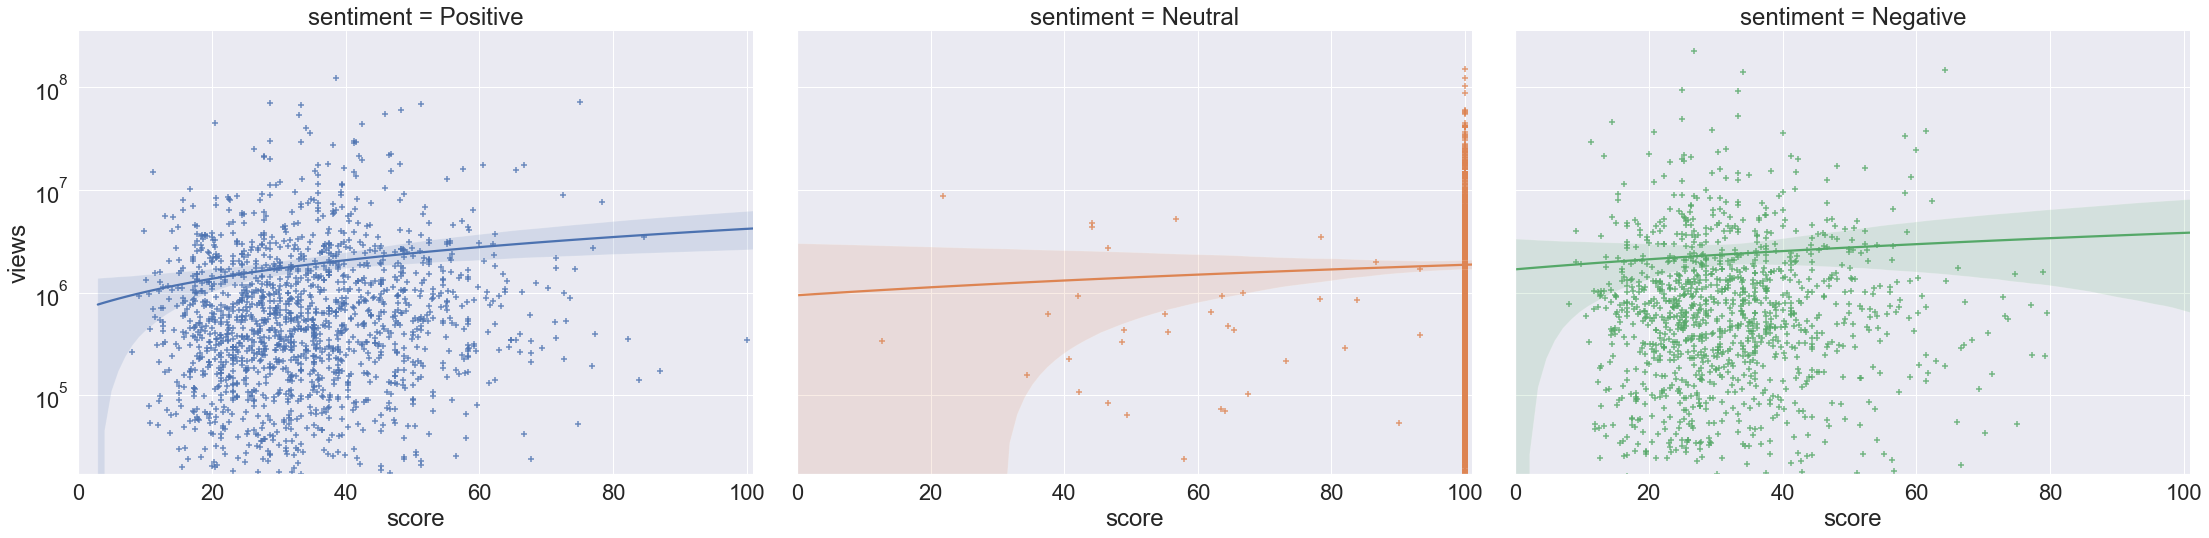

In [392]:
cond = df_unique['title_rate'] == 'Positive'
df1 = df_unique[cond][['title_positive','views', 'title_rate']]
df1.rename(columns={ 'title_positive' : 'score', 
                     'title_rate' : 'sentiment'
                   },inplace=True)

cond = df_unique['title_rate'] == 'Neutral'
df2 = df_unique[cond][['title_neutral','views', 'title_rate']]
df2.rename(columns={ 'title_neutral' : 'score', 
                     'title_rate' : 'sentiment'
                   },inplace=True)

cond = df_unique['title_rate'] == 'Negative'
df3 = df_unique[cond][['title_negative','views', 'title_rate']]
df3.rename(columns={ 'title_negative' : 'score', 
                     'title_rate' : 'sentiment'
                   },inplace=True)

sns.set(font_scale=2)
df_regplot = pd.concat([df1, df2, df3])

kws = dict(s=50, linewidth=.5, edgecolor="w")

ax = sns.lmplot(x='score', y='views', col='sentiment', data=df_regplot, aspect=1.3, height=8,
                legend=True, hue='sentiment', markers='+',col_wrap=3)

ax.set(xlim=(0, 101))
ax.set(xscale='linear', yscale='log')


plt.tight_layout()
plt.show()

In [394]:
# y={0:.1f}x+{1:.1f}

summary_data = []

slope, intercept, r_value, p_value, std_err = stats.linregress(x=np.log10(df1['score']), y=np.log10(df1['views']))
summary_data.append({'Score': 'Positive', 'Slope' : slope, 'Y-Intercept': intercept})

slope, intercept, r_value, p_value, std_err = stats.linregress(x=np.log10(df2['score']), y=np.log10(df2['views']))
summary_data.append({'Score': 'Neutral', 'Slope' : slope, 'Y-Intercept': intercept})

slope, intercept, r_value, p_value, std_err = stats.linregress(x=np.log10(df3['score']), y=np.log10(df3['views']))
summary_data.append({'Score': 'Negative', 'Slope' : slope, 'Y-Intercept': intercept})


pd.DataFrame(data=summary_data, columns=list(summary_data[0].keys()))

,Score,Slope,Y-Intercept
0,Positive,0.468261,4.938652
1,Neutral,-0.064600,5.763415
2,Negative,0.111647,5.508975


##### OLS Regression for Positive Sentiment

In [395]:
model = sm.OLS(endog=np.log10(df1['views']), exog=np.log10(df1['score']))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  views   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 5.762e+04
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:38:58   Log-Likelihood:                -2267.0
No. Observations:                1656   AIC:                             4536.
Df Residuals:                    1655   BIC:                             4541.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
score          3.7202      0.015    240.045      0.000       3.690       3.751
==============================================================================
Omnibus:                        2.917   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.233   Jarque-Bera (JB):                2.821
Skew:                          -0.096   Prob(JB):                        0.244
Kurtosis:                       3.062   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### OLS Regression for Neutral Sentiment

In [396]:
model = sm.OLS(endog=np.log10(df2['views']), exog=np.log10(df2['score']))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  views   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 1.639e+05
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:39:22   Log-Likelihood:                -4273.5
No. Observations:                3493   AIC:                             8549.
Df Residuals:                    3492   BIC:                             8555.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
score          2.8203      0.007    404.793      0.000       2.807       2.834
==============================================================================
Omnibus:                      144.089   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.352
Skew:                          -0.472   Prob(JB):                     1.68e-37
Kurtosis:                       3.523   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### OLS Regression for Negative Sentiment

In [397]:
model = sm.OLS(endog=np.log10(df3['views']), exog=np.log10(df3['score']))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  views   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 3.674e+04
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:39:39   Log-Likelihood:                -1729.1
No. Observations:                1202   AIC:                             3460.
Df Residuals:                    1201   BIC:                             3465.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
score          3.7955      0.020    191.677      0.000       3.757       3.834
==============================================================================
Omnibus:                       18.855   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.720
Skew:                          -0.237   Prob(JB):                     1.92e-05
Kurtosis:                       3.457   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Correlation between Tags Sentiment and Views

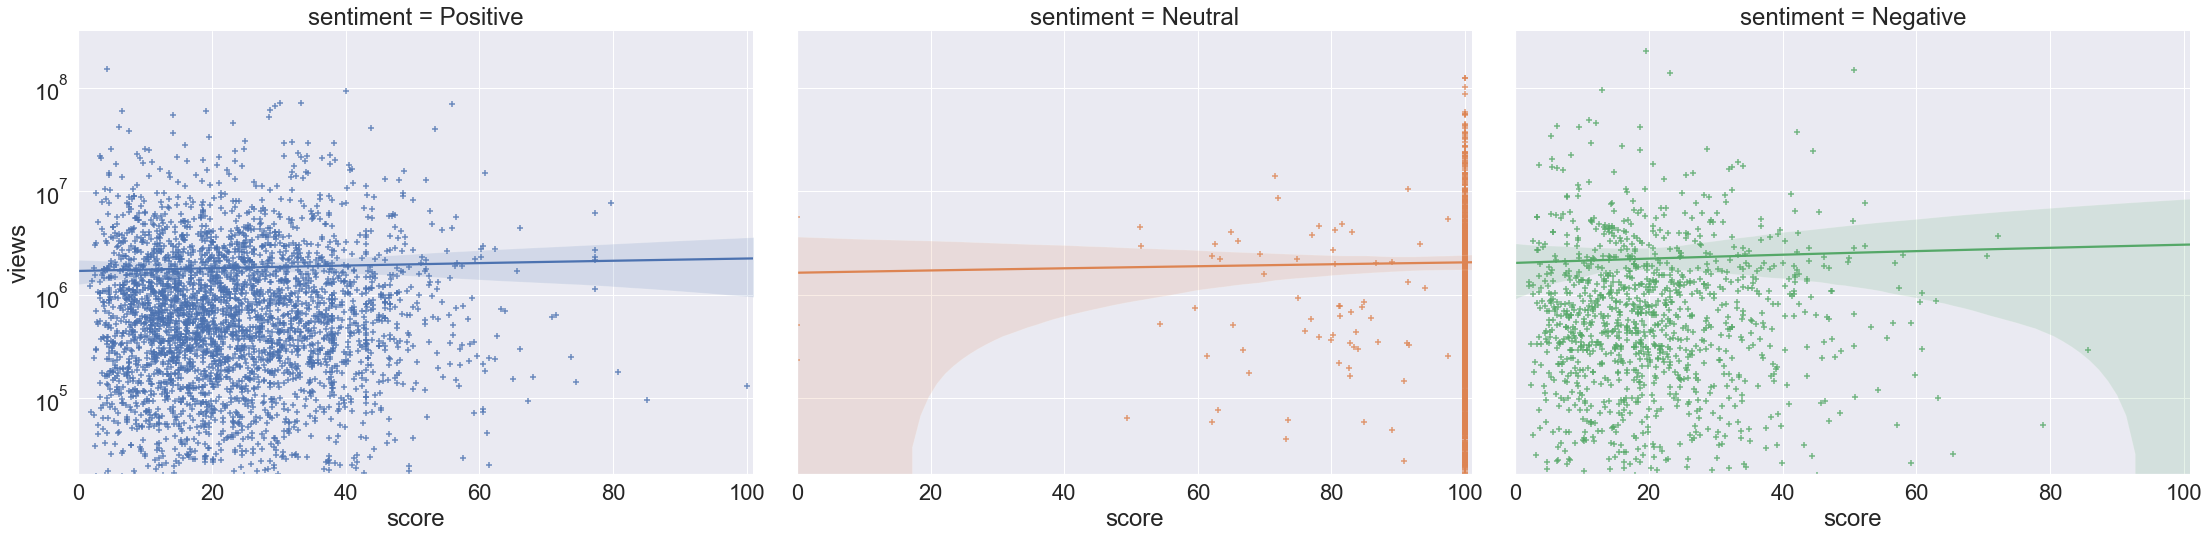

In [25]:
cond = df_unique['tags_rate'] == 'Positive'
df1 = df_unique[cond][['tags_positive','views', 'tags_rate']]
df1.rename(columns={ 'tags_positive' : 'score', 
                     'tags_rate' : 'sentiment'
                   },inplace=True)

cond = df_unique['tags_rate'] == 'Neutral'
df2 = df_unique[cond][['tags_neutral','views', 'tags_rate']]
df2.rename(columns={ 'tags_neutral' : 'score', 
                     'tags_rate' : 'sentiment'
                   },inplace=True)

cond = df_unique['tags_rate'] == 'Negative'
df3 = df_unique[cond][['tags_negative','views', 'tags_rate']]
df3.rename(columns={ 'tags_negative' : 'score', 
                     'tags_rate' : 'sentiment'
                   },inplace=True)

sns.set(font_scale=2)
df_regplot = pd.concat([df1, df2, df3])

kws = dict(s=50, linewidth=.5, edgecolor="w")

ax = sns.lmplot(x='score', y='views', col='sentiment', data=df_regplot, aspect=1.3, height=8,
                legend=True, hue='sentiment', markers='+',col_wrap=3)

ax.set(xlim=(0, 101))
ax.set(xscale='linear', yscale='log')


plt.tight_layout()
plt.show()

In [398]:
# y={0:.1f}x+{1:.1f}

summary_data = []

slope, intercept, r_value, p_value, std_err = stats.linregress(x=np.log10(df1['score']), y=np.log10(df1['views']))
summary_data.append({'Score': 'Positive', 
                     'Slope' : slope, 
                     'Y-Intercept': intercept,
                     'P-Value' : p_value,
                     'Standard Error' : std_err
                    })

slope, intercept, r_value, p_value, std_err = stats.linregress(x=np.log10(df2['score']), y=np.log10(df2['views']))
summary_data.append({'Score': 'Neutral', 
                     'Slope' : slope, 
                     'Y-Intercept': intercept,
                     'P-Value' : p_value,
                     'Standard Error' : std_err
                    })


slope, intercept, r_value, p_value, std_err = stats.linregress(x=np.log10(df3['score']), y=np.log10(df3['views']))
summary_data.append({'Score': 'Negative', 
                     'Slope' : slope, 
                     'Y-Intercept': intercept,
                     'P-Value' : p_value,
                     'Standard Error' : std_err
                    })

pd.DataFrame(data=summary_data, columns=list(summary_data[0].keys()))

,Score,Slope,Y-Intercept,P-Value,Standard Error
0,Positive,0.468261,4.938652,0.000021,0.109774
1,Neutral,-0.064600,5.763415,0.882960,0.438774
2,Negative,0.111647,5.508975,0.429688,0.141326


### Top 10 Creators & Categories
____________________________

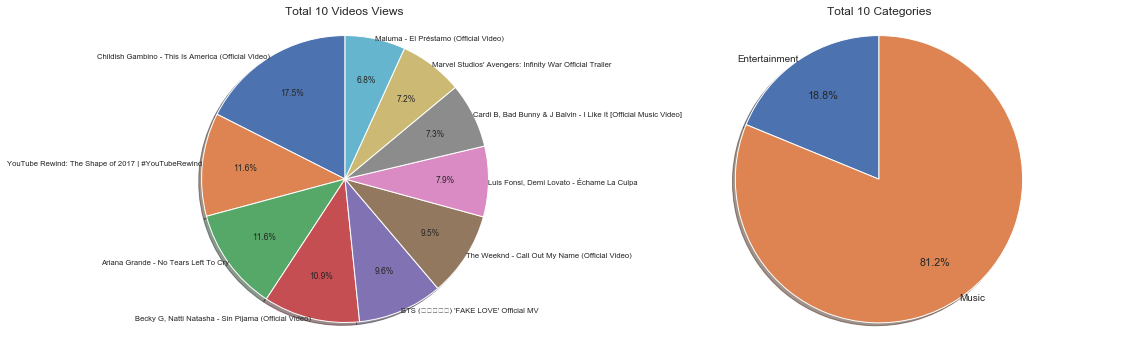

In [31]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)


df_top = df_unique[['views', 'title', 'category_name', 'channel_title' ]].nlargest(n=10,columns=['views'])

ax1.pie(x=df_top['views'], labels=df_top['title'], shadow=True, startangle=90, autopct='%1.1f%%',labeldistance=1.0,pctdistance=0.7)
ax1.set_title('Total 10 Videos Views', fontsize=12)
ax1.axis('equal')
ax1.set_xlim(auto=True)
ax1.set_ylim(auto=True)
sns.set(font_scale=0.9)

df_top_cat = df_top[['category_name', 'views']].groupby('category_name', as_index=False).sum()
ax2.pie(x=df_top_cat['views'], labels=df_top_cat['category_name'], shadow=True, startangle=90, autopct='%1.1f%%',labeldistance=1.0,pctdistance=0.7)
ax2.set_title('Total 10 Categories', fontsize=12)
ax2.axis('equal')
ax2.set_xlim(auto=True)
ax2.set_ylim(auto=True)

plt.tight_layout()
plt.show()

#### Music & Entertainment Categories Versus Everything else 

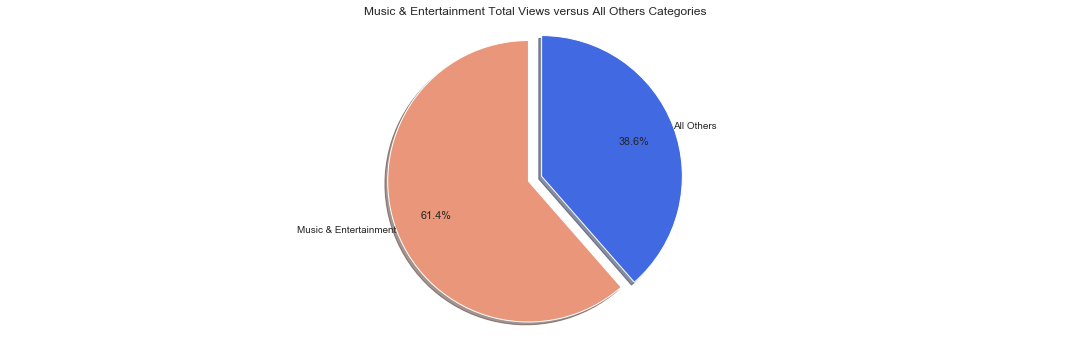

In [104]:
cond = (df_unique['category_name'] == 'Music') | (df_unique['category_name'] == 'Entertainment')
total_music_enter = df_unique[cond]['views'].sum()

cond = (df_unique['category_name'] != 'Music') & (df_unique['category_name'] != 'Entertainment')
total_others = df_unique[cond]['views'].sum()

summary_data = [{
        'Category' : 'Music & Entertainment',
        'Views'    : total_music_enter},
    {
        'Category' : 'All Others',
        'Views'    : total_others
    }
]

df_compare = pd.DataFrame(data=summary_data, columns=list(summary_data[0].keys()))

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 1, 1)

explode= (0.1, 0)
colors = ['darksalmon','royalblue']


ax1.pie(x=df_compare['Views'], labels=df_compare['Category'], shadow=True, startangle=90, autopct='%1.1f%%',
        labeldistance=1.0, pctdistance=0.7, explode=explode, colors=colors)
ax1.set_title('Music & Entertainment Total Views versus All Others Categories', fontsize=12)
ax1.axis('equal')
ax1.set_xlim(auto=True)
ax1.set_ylim(auto=True)

plt.tight_layout()
plt.show()


#### Videos Duration

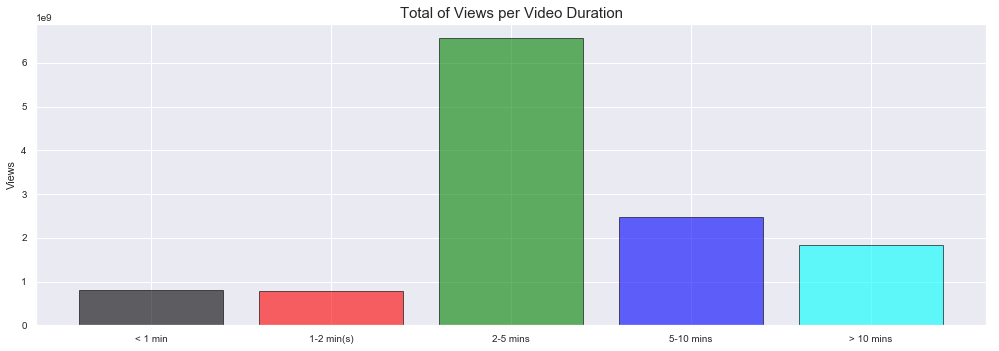

In [152]:
size_bins = [-1, 60, 120, 300, 600]
group_names = ['< 1 min', '1-2 min(s)', '2-5 mins', '5-10 mins', '> 10 mins']
color = ['black', 'red', 'green', 'blue', 'cyan']
size_bins.append(df_unique['duration'].max()+1)
video_columns = ['duration', 'views']

df_videos = df_unique[video_columns].copy(deep=True)
df_videos['Videos Range'] = pd.cut(df_videos['duration'],size_bins, labels=group_names)

df_videos_agg  = df_videos.groupby(by='Videos Range', as_index=False).agg({
                                        'views' : ['sum']
                                    })

fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1, 1, 1)

ax.bar(df_videos_agg['Videos Range'], df_videos_agg['views']['sum'], align="center", alpha=0.6, orientation='vertical', color=color, edgecolor='black')

ax.set_title('Total of Views per Video Duration', fontsize=15)
ax.set_ylabel('Views')
ax.set_xlim(auto=True)
ax.set_ylim(auto=True)
ax.set_yscale('linear')

plt.tight_layout()
plt.show()

### Correlation between Creator Subscribers/Total of Videos and Views

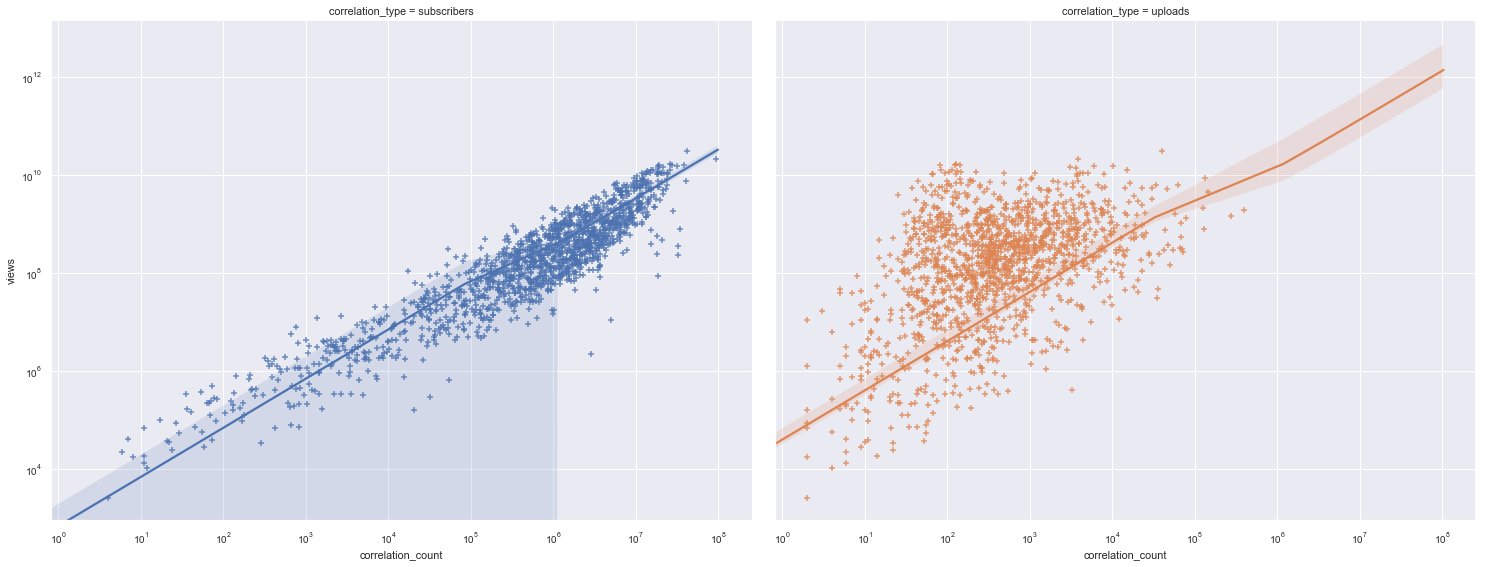

In [384]:
cond = (creators['viewCount'] > 0) & (creators['videoCount'] > 0) & (creators['subscriberCount'] > 0)

creators_corr = creators[cond][['channel_id', 'subscriberCount', 'videoCount', 'viewCount']].groupby('channel_id').last()

df1 = creators_corr[['subscriberCount', 'viewCount']].copy(deep=True)
df1.rename(columns={'subscriberCount' : 'correlation_count', 'viewCount' : 'views'}, inplace=True)
df1['correlation_type'] = 'subscribers'

df2 = creators_corr[['videoCount', 'viewCount']].copy(deep=True)
df2.rename(columns={'videoCount' : 'correlation_count', 'viewCount' : 'views'}, inplace=True)
df2['correlation_type'] = 'uploads'

df_creators_plot = pd.concat([df1, df2])

ax = sns.lmplot(x='correlation_count', y='views', col='correlation_type', data=df_creators_plot, aspect=1.3, height=8,
                legend=True, hue='correlation_type', markers='+',col_wrap=2)

ax.set(xscale='log', yscale='log')

plt.tight_layout()
plt.show()

#ax = sns.lmplot(x='subscriberCount', y='viewCount', data=creators, aspect=1.3, height=8,  legend=True, markers='+')

In [386]:
# y={0:.1f}x+{1:.1f}
summary_data = []

slope, intercept, r_value, p_value, std_err = stats.linregress(x=np.log10(df1['correlation_count']), y=np.log10(df1['views']))
summary_data.append({'Correlation': 'subscribers', 
                     'Slope' : slope, 
                     'Y-Intercept': intercept,
                     'P-Value' : p_value,
                     'Standard Error' : std_err
                    })

slope, intercept, r_value, p_value, std_err = stats.linregress(x=np.log10(df2['correlation_count']), y=np.log10(df2['views']))
summary_data.append({'Correlation': 'uploads', 
                     'Slope' : slope, 
                     'Y-Intercept': intercept,
                     'P-Value' : p_value,
                     'Standard Error' : std_err
                    })

pd.DataFrame(data=summary_data, columns=list(summary_data[0].keys()))

#np.log10(df1['views'])

,Correlation,Slope,Y-Intercept,P-Value,Standard Error
0,subscribers,0.832839,3.433148,0.000000e+00,0.008720
1,uploads,0.616388,6.535054,2.727199e-77,0.031222


##### OLS Regression for Subscribers

In [389]:
model = sm.OLS(endog=np.log10(df1['views']), exog=np.log10(df1['correlation_count']))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  views   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.328e+05
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:27:34   Log-Likelihood:                -1911.9
No. Observations:                1499   AIC:                             3826.
Df Residuals:                    1498   BIC:                             3831.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
correlation_count     1.4131      0.004    364.405      0.000       1.406       1.421
==============================================================================
Omnibus:                      244.249   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              415.554
Skew:                           1.044   Prob(JB):                     5.80e-91
Kurtosis:                       4.514   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### OLS Regression for Uploads

In [390]:
model = sm.OLS(endog=np.log10(df2['views']), exog=np.log10(df2['correlation_count']))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  views   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                 1.816e+04
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:27:41   Log-Likelihood:                -3352.1
No. Observations:                1499   AIC:                             6706.
Df Residuals:                    1498   BIC:                             6711.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
correlation_count     2.9096      0.022    134.756      0.000       2.867       2.952
==============================================================================
Omnibus:                       25.360   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.384
Skew:                          -0.325   Prob(JB):                     1.87e-06
Kurtosis:                       2.991   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Content creators performance
___________________________________
Music & Entertainment are not include in this study

In [257]:
cond = (df_unique['category_name'] != 'Music') & (df_unique['category_name'] != 'Entertainment')

df_channel = df_unique[cond][['channel_title', 'views', 'category_name']].groupby(by=['category_name', 'channel_title'], as_index=False).sum()
df_channel['views'] = np.log10(df_channel['views'])

df_channel = df_channel.pivot('channel_title', 'category_name', 'views')
df_channel.fillna(value=0, inplace=True)



fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)

ax.set_title('Content creators total of views performance', fontsize=15)

ax = sns.heatmap(df_channel, annot=True, cmap='YlGnBu')

plt.tight_layout()
plt.show()


#ax = sns.heatmap(df_corr, annot=True, fmt='.2f',vmin=-1.0, vmax=1.0, cmap='YlGnBu', center=0, linewidths=.5)
#sns.heatmap(df_channel, cmap='YlGnBu')

#df_channel = df_unique[cond][['channel_title', 'views', 'category_name']].sort_values(by='views', ascending=False).head(20).groupby(by='channel_title', as_index=False).agg({
#    'views' : ['count', 'sum']
#})

#df_channel['channel_title']
#df_channel['views']['count']
#df_channel['views']['sum']


#fig = plt.figure(figsize=(15, 7))
#ax1 = fig.add_subplot(1, 2, 1)
#ax2 = fig.add_subplot(1, 2, 2)

#ax1.bar(df_channel['channel_title'], df_channel['views']['sum'],align="center", alpha=0.6, orientation='vertical',log=True)
#ax1.set_title('Total Creator Views', fontsize=15)
#ax1.set_xlabel('Creator')
#ax1.set_ylabel('Views')
#ax1.set_xticklabels(df_channel['channel_title'], rotation='vertical')
#ax1.set_xlim(auto=True)
#ax1.set_ylim(auto=True)


#ax2.pie(x=df_category['views']['count'], labels=df_category['category_name'], shadow=True, startangle=90, autopct='%1.1f%%',labeldistance=1.0,pctdistance=0.7)
#ax2.set_title('Total of Videos Per Category', fontsize=15)
#ax2.axis('equal')
#ax2.set_xlim(auto=True)
#ax2.set_ylim(auto=True)

#plt.tight_layout()
#plt.show()




KeyError: 'views'

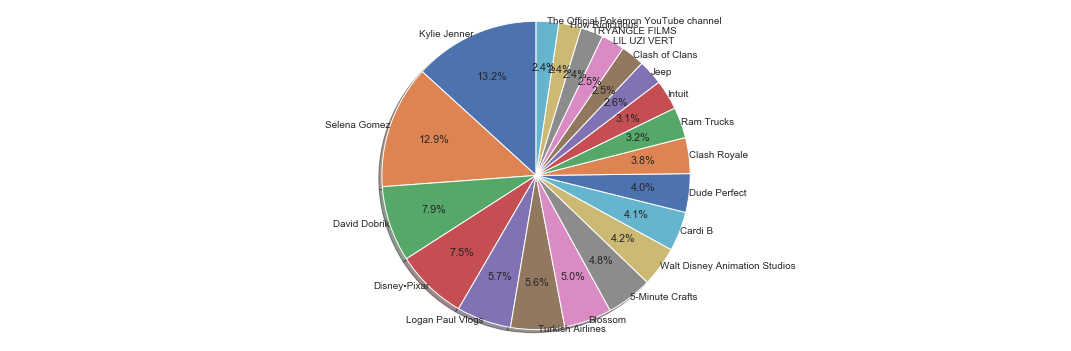

In [282]:
cond = (df_unique['category_name'] != 'Music') & (df_unique['category_name'] != 'Entertainment')

df_channel = df_unique[cond][['channel_title', 'views']].groupby(by=['channel_title'], as_index=False).agg({
    'views' : ['count', 'sum']
})

df_channel


# total_distance = 100m
# total_time    =  30s
# ratio (distance/time) = 100/30 = 3.3 m/s

# total_views  = 1500
# total_videos = 5
# ratio = (views / video) = 1500/5 = 300 views/video
# each video has 300 views


df_channel['ratio'] = df_channel['views']['sum']/df_channel['views']['count']
df_channel = df_channel.sort_values(by='ratio', ascending=False).head(20)


fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 1, 1)


ax1.pie(x=df_channel['ratio'], labels=df_channel['channel_title'], shadow=True, startangle=90, autopct='%1.1f%%',
        labeldistance=1.0, pctdistance=0.7)
#ax1.set_title('Music & Entertainment Total Views versus All Others Categories', fontsize=12)

ax1.axis('equal')
ax1.set_xlim(auto=True)
ax1.set_ylim(auto=True)

plt.tight_layout()
plt.show()



In [572]:
#df[columns].groupby(by='video_id').sum().to_csv('data.csv')
df.to_csv('data.csv')

#### 1. Videos Summary

In [26]:
total_videos = df['video_id'].nunique()

df[columns].groupby(by='video_id').mean()

#print (total_videos)

,views,likes,comment_count
video_id,,,
-0CMnp02rNY,6.891170e+05,8699.500000,369.166667
-0NYY8cqdiQ,5.637460e+05,4429.000000,94.000000
-1Hm41N0dUs,1.835892e+06,37388.333333,1462.000000
-1yT-K3c6YI,1.943108e+05,6826.250000,732.000000
-2RVw2_QyxQ,6.943467e+04,450.333333,20.666667
-2aVkGcI7ZA,1.668644e+06,29818.000000,732.000000
-2b4qSoMnKE,1.881985e+05,2616.000000,2351.500000
-2wRFv-mScQ,8.928958e+05,11705.750000,656.500000
-35jibKqbEo,1.476342e+06,104394.750000,7598.000000
